In [1]:
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import csv
from zipfile import ZipFile

In [18]:
url = "https://www.ssa.gov/oact/babynames/names.zip"

with requests.get(url) as response:

    with open("names.zip", "wb") as temp_file:
        temp_file.write(response.content)


# This list will hold all our data. We initialize it with the header row.
data_list = [["year", "name", "gender", "count"]]

# We first read the zip file using a zipfile.ZipFile object.
with ZipFile("names.zip") as temp_zip:

    # Then we read the file list.
    for file_name in temp_zip.namelist():

        # We will only process .txt files.
        if ".txt" in file_name:

            # Now we read the current file from the zip file.
            with temp_zip.open(file_name) as temp_file:

                # The file is opened as binary, we decode it using utf-8 so it can be manipulated as a string.
                for line in temp_file.read().decode("utf-8").splitlines():

                    # We prepare our desired data fields and add them to the data list.
                    line_chunks = line.split(",")
                    year = file_name[3:7]
                    name = line_chunks[0]
                    gender = line_chunks[1]
                    count = line_chunks[2]

                    data_list.append([year, name, gender, count])

# We save the data list into a csv file.
csv.writer(open("data.csv", "w", newline="",
                encoding="utf-8")).writerows(data_list)

ConnectionError: HTTPSConnectionPool(host='www.ssa.gov', port=443): Max retries exceeded with url: /oact/babynames/names.zip (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x00000248BAD8A0E0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

In [19]:
df = pd.read_csv("data.csv")
print(f"All Name Records Since 1880: {len(df.index)}")
print(f"Min Year: {df['year'].min()} to Max Year: {df['year'].max()}")

All Name Records Since 1880: 2052781
Min Year: 1880 to Max Year: 2021


In [20]:
df.head()

,year,name,gender,count
0,1880,Mary,F,7065
1,1880,Anna,F,2604
2,1880,Emma,F,2003
3,1880,Elizabeth,F,1939
4,1880,Minnie,F,1746


## Calculate and Merge in Total Births for Each Year, then Total per Gender per Year

In [4]:
df = df.merge(
        df.groupby(["year"], as_index=False)["count"].sum().rename(columns={"count": "year_total"}),
        how="left",
        on=["year"],
    )
df.head()

,year,name,gender,count,year_total
0,1880,Mary,F,7065,201484
1,1880,Anna,F,2604,201484
2,1880,Emma,F,2003,201484
3,1880,Elizabeth,F,1939,201484
4,1880,Minnie,F,1746,201484


In [5]:
df = df.merge(
        df.groupby(["year", "gender"], as_index=False)["count"].sum().rename(columns={"count": "year_gender_total"}),
        how="left",
        on=["year", "gender"],
    )
df.head()

,year,name,gender,count,year_total,year_gender_total
0,1880,Mary,F,7065,201484,90994
1,1880,Anna,F,2604,201484,90994
2,1880,Emma,F,2003,201484,90994
3,1880,Elizabeth,F,1939,201484,90994
4,1880,Minnie,F,1746,201484,90994


## Calculate Proportions per total and gender per year

In [6]:
df['gender_proportion'] = df['count'] / df['year_gender_total']
df['total_proportion'] = df['count'] / df['year_total']
df.head()

,year,name,gender,count,year_total,year_gender_total,gender_proportion,total_proportion
0,1880,Mary,F,7065,201484,90994,0.077642,0.035065
1,1880,Anna,F,2604,201484,90994,0.028617,0.012924
2,1880,Emma,F,2003,201484,90994,0.022012,0.009941
3,1880,Elizabeth,F,1939,201484,90994,0.021309,0.009624
4,1880,Minnie,F,1746,201484,90994,0.019188,0.008666


## Determine Most Popular Year for Each Name by Total Names Given -> df2

In [7]:
popular_years = (
    df.merge(
        df.groupby(["name", "gender"], as_index=False)["count"].max(),
        how="inner",
        on=["name", "gender", "count"],
    )
    .groupby(["name", "gender"], as_index=False)["year"]
    .max()
    .rename(columns={"year": "year_pop"}, inplace=False)
)

df2 = df.merge(popular_years.rename(columns={"year_pop": "year"}), how='inner', on=['name', 'gender', 'year'])
print(f"Length of df2: {len(df2.index)}")
print(f"Number of unique names: {len(df2['name'].unique())}")
df2.head()

Length of df2: 112620
Number of unique names: 101338


,year,name,gender,count,year_total,year_gender_total,gender_proportion,total_proportion
0,1880,Manerva,F,10,201484,90994,0.000110,0.000050
1,1880,Neppie,F,7,201484,90994,0.000077,0.000035
2,1880,Arch,M,61,201484,110490,0.000552,0.000303
3,1880,Redden,M,6,201484,110490,0.000054,0.000030
4,1880,Merida,M,5,201484,110490,0.000045,0.000025


In [8]:
df2[df2['name'] == 'Ryan']

,year,name,gender,count,year_total,year_gender_total,gender_proportion,total_proportion
32997,1985,Ryan,M,29912,3569087,1848322,0.016183,0.008381
95710,2018,Ryan,F,865,3508655,1696917,0.000510,0.000247


## Determine Most Popular Year for Each Name by Proportion of Total Names Given -> df2

In [9]:
popular_proportion_years = (
    df.merge(
        df.groupby(["name", "gender"], as_index=False)["total_proportion"].max(),
        how="inner",
        on=["name", "gender", "total_proportion"],
    )
    .groupby(["name", "gender"], as_index=False)["year"]
    .max()
    .rename(columns={"year": "year_pop"}, inplace=False)
)

c = df.merge(popular_proportion_years.rename(columns={"year_pop": "year"}), how='inner', on=['name', 'gender', 'year'])
print(f"Length of df2: {len(c.index)}")
print(f"Number of unique names: {len(c['name'].unique())}")
c.head()

Length of df2: 112620
Number of unique names: 101338


,year,name,gender,count,year_total,year_gender_total,gender_proportion,total_proportion
0,1880,Harriet,F,319,201484,90994,0.003506,0.001583
1,1880,Kate,F,299,201484,90994,0.003286,0.001484
2,1880,Cordelia,F,58,201484,90994,0.000637,0.000288
3,1880,Lina,F,49,201484,90994,0.000538,0.000243
4,1880,John,F,46,201484,90994,0.000506,0.000228


In [10]:
d = c[c['name'] == 'Ryan']
d

,year,name,gender,count,year_total,year_gender_total,gender_proportion,total_proportion
36907,1985,Ryan,M,29912,3569087,1848322,0.016183,0.008381
95394,2018,Ryan,F,865,3508655,1696917,0.000510,0.000247


In [11]:
# Those parameters generate plots with a mauve color.
sns.set(style="ticks",
        rc={
            "figure.figsize": [12, 7],
            "text.color": "white",
            "axes.labelcolor": "white",
            "axes.edgecolor": "white",
            "xtick.color": "white",
            "ytick.color": "white",
            "axes.facecolor": "#443941",
            "figure.facecolor": "#443941"}
        )

## Look at some General Trends with the overall Numbers -> df3

In [12]:
df.head()

,year,name,gender,count,year_total,year_gender_total,gender_proportion,total_proportion
0,1880,Mary,F,7065,201484,90994,0.077642,0.035065
1,1880,Anna,F,2604,201484,90994,0.028617,0.012924
2,1880,Emma,F,2003,201484,90994,0.022012,0.009941
3,1880,Elizabeth,F,1939,201484,90994,0.021309,0.009624
4,1880,Minnie,F,1746,201484,90994,0.019188,0.008666


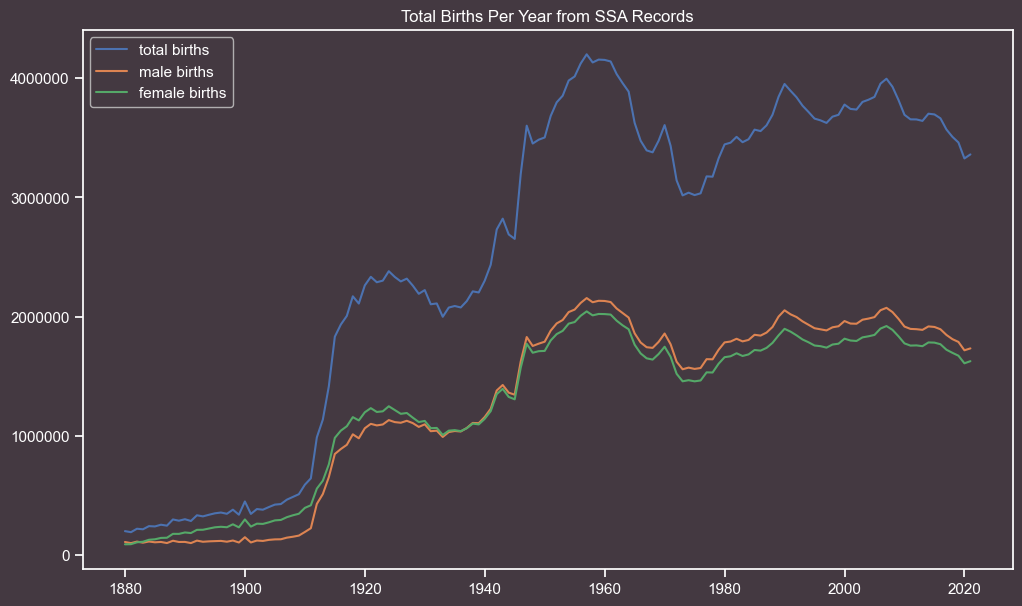

In [13]:
df3 = df.groupby('year', as_index=False)['count'].sum()

df3 = df3.merge(
    df[df['gender'] == 'M'].rename(columns={"count": "male_count"}, inplace=False).groupby('year', as_index=False)['male_count'].sum(),
    how='left',
    on='year'
)

df3 = df3.merge(
    df[df['gender'] == 'F'].rename(columns={"count": "female_count"}, inplace=False).groupby('year', as_index=False)['female_count'].sum(),
    how='left',
    on='year'
)

plt.plot(df3['year'], df3['count'], label='total births')
plt.plot(df3['year'], df3['male_count'], label='male births')
plt.plot(df3['year'], df3['female_count'], label='female births')
plt.ticklabel_format(style='plain')
plt.title(f"Total Births Per Year from SSA Records")
plt.legend();

## Pandas Profile Report

In [16]:
try:
    import pandas as pd
    from pandas_profiling import ProfileReport
    import os
except:
    !pip install --user pandas-profiling
    !jupyter nbextension enable --py widgetsnbextension
    print('Restart the Kernel before proceeding')

profile = ProfileReport(df, explorative=True, minimal=False)
profile.to_file('baby_report.html')
print('File report.html saved to '+os.getcwd())

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\z0f010w\PycharmProjects\baby_project\venv\lib\site-packages\multimethod\__init__.py:315: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  return func(*args, **kwargs)


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

File report.html saved to C:\Users\z0f010w\PycharmProjects\baby_project


In [ ]:
def plot_specific_names(names):

    for name in names:
        name_df = df[df['name'] == name]
        male_df = name_df[name_df['gender'] == 'M']
        female_df = name_df[name_df['gender'] == 'F']

        if len(male_df.index) > 0:
            plt.plot(male_df['year'], male_df['gender_proportion'], label=f'{name} - Male')
        else:
            print(f"No Males Named {name} since 1880.")

        if len(female_df.index) > 0:
            plt.plot(female_df['year'], female_df['gender_proportion'], label=f'{name} - Female')
        else:
            print(f"No Females Named {name} since 1880.")

    plt.title(f'{names} as % of all names each year')
    plt.legend()

def get_names_starts_with(starts_with, gender, df):
    unique_gender_filter = df[df['gender'] == gender]
    unique_starts_with_series = unique_gender_filter[unique_gender_filter['name'].str.startswith(starts_with)]['name'].unique()
    # Group by name, merge into the series
    df = None
    df = unique_starts_with_series.merge(
        unique_starts_with_series.groupby('name', as_index=False)['count'].sum(),
        how='inner',
        on='name')

    return df

def get_popular_starts_with(starts_with):
    return None

In [ ]:
plot_specific_names(['Raya', 'Ryan'])

In [ ]:
# Find names that were popular before x date and have become popular since x date?
a = get_names_starts_with('B', 'F', df2)
a.head()

In [ ]:
# Names that used to be more popular in one gender but are becoming more popular in another gender
# Predictions for names by letter (top 10)?
# Top "unusually names per year" and predictions for next year based on current trends